In [17]:
from dataclasses import dataclass
from typing import Callable

import pandas as pd
import os, json, re

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.cluster import KMeans

import pprint

SAMPLE_DIR = './sample/samples-1000'

# Data exploration and transformation

## price analysis

In [2]:
prices = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith('.json'):
        with open(os.path.join(SAMPLE_DIR, file)) as f:
            data = json.load(f)
            prices.append(data['note'])
prices

['~b/o 4 chaos',
 '~price 2 divine',
 '~price 4 chaos',
 '~b/o 1 divine',
 '~price 50 chaos',
 '~b/o 58 chaos',
 '~price 10 chaos',
 '~price 10 chaos',
 '~price 9 chaos',
 '~b/o 50 chaos',
 '~price 3 chaos 4',
 '~b/o 31 chaos',
 '~price 1 chaos',
 '~b/o 5 chaos',
 '~price 2 chaos veiled',
 '~price 5 chaos',
 '~price 1 divine',
 '~price 2 chaos',
 '~b/o 30 chaos',
 '~b/o 31 chaos',
 '~b/o 1 divine',
 '~b/o 2 divine',
 '~price 5 chaos',
 '~price 3 chaos',
 '~price 20 chaos',
 '~price 10 chaos',
 '~price 2 chaos',
 '~price 6 chaos',
 '~b/o 8 chaos',
 '~price 3 chaos',
 '~price 10 chaos',
 '~price 3 chaos',
 '~price 15 chaos',
 '~price 1 divine',
 '~price 6 chaos',
 '~price 15 chaos',
 '~price 6 chaos',
 '~price 20 chaos 1',
 '~price 2 chaos',
 '~price 6 chaos',
 '~price 10 chaos',
 '~b/o 1 divine',
 '~b/o 5 chaos',
 '~price 1 chaos',
 '~price 1 chaos 6',
 '~b/o 6 chaos',
 '~price 8 chaos',
 '~b/o 5 chaos',
 '~price 1 divine',
 '~price 2 chaos veiled',
 '~price 1 chaos',
 '~b/o 20 chaos',


In [3]:
@dataclass
class PatternConverter:
    pattern: re.Pattern
    conversion_factor: Callable[[str], float]


chaos_pattern = PatternConverter(re.compile(r'^~price \d+ chaos$'), lambda s: int(s.split()[1]))
bo_chaos_pattern = PatternConverter(re.compile(r'^~b/o \d+ chaos$'), lambda s: int(s.split()[1]))
divine_pattern = PatternConverter(re.compile(r'^~price \d+ divine$'), lambda s: int(s.split()[1]) * 165)
bo_divine_pattern = PatternConverter(re.compile(r'^~b/o \d+ divine$'), lambda s: int(s.split()[1]) * 165)
chaos_veiled_pattern = PatternConverter(re.compile(r'^~price \d+ chaos veiled$'), lambda s: int(s.split()[1]) * 74.5)
bo_chaos_veiled_pattern = PatternConverter(re.compile(r'^~b/o \d+ chaos veiled$'), lambda s: int(s.split()[1]) * 74.5)

def match_any_patten_and_convert(string: str) -> float | None:
    for pattern in [chaos_pattern, bo_chaos_pattern, divine_pattern, bo_divine_pattern, chaos_veiled_pattern, bo_chaos_veiled_pattern]:
        if pattern.pattern.match(string):
            return pattern.conversion_factor(string)
    return None

filtered_prices = [interpreted_price for price in prices if (interpreted_price := match_any_patten_and_convert(price)) is not None]
filtered_out_prices = [price for price in prices if not match_any_patten_and_convert(price)]
# filtered_prices_values = [int(price.split()[1]) for price in filtered_prices]


In [4]:
price_distribution = pd.Series(filtered_prices).value_counts().sort_index()
price_distribution

0.0         1
1.0        63
2.0        72
3.0        72
4.0        20
5.0       128
6.0        50
7.0         3
8.0        19
9.0        13
10.0      100
11.0       16
12.0       12
14.0        4
15.0       41
17.0        1
19.0        1
20.0       90
22.0        3
23.0        4
25.0        7
28.0       28
29.0        1
30.0       18
31.0       11
33.0        1
35.0        2
38.0        2
40.0        7
45.0        2
48.0        4
49.0        2
50.0       42
55.0        2
58.0        3
59.0        2
60.0        2
66.0        2
68.0        1
69.0        2
70.0        2
75.0        1
80.0        7
88.0        1
90.0        1
99.0        2
100.0       5
120.0       1
130.0       1
140.0       1
149.0      37
160.0       1
165.0      38
300.0       2
330.0      13
5115.0      1
Name: count, dtype: int64

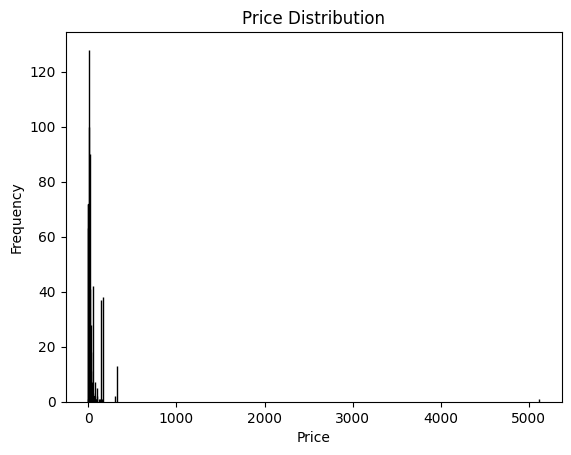

In [5]:
plt.bar(price_distribution.index, price_distribution.values, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

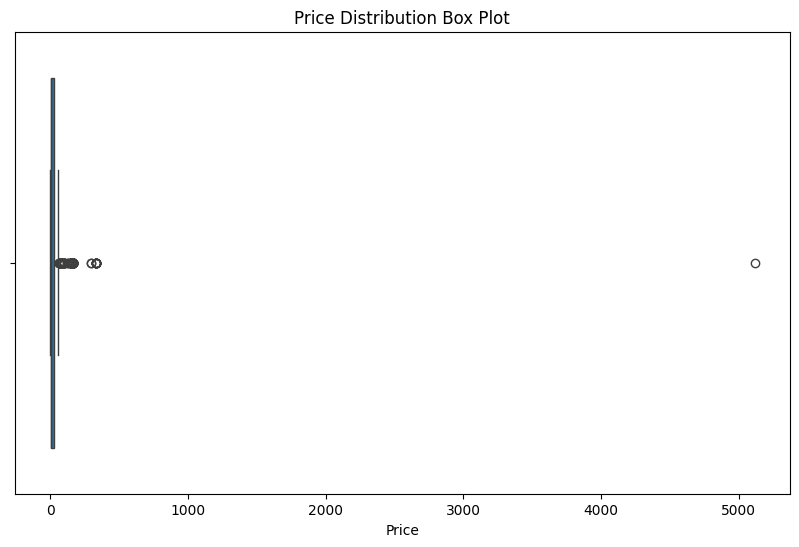

In [6]:
df = pd.DataFrame(filtered_prices, columns=['Price'])

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title('Price Distribution Box Plot')
plt.xlabel('Price')
plt.show()

## Outlier removal

In [9]:
@dataclass
class PriceWithFileName:
    name: str
    price_note: str
    price: float | None

prices_with_name = []
for file in os.listdir(SAMPLE_DIR):
    if file.endswith('.json'):
        with open(os.path.join(SAMPLE_DIR, file)) as f:
            data = json.load(f)
            prices_with_name.append(PriceWithFileName(file, data['note'], match_any_patten_and_convert(data['note'])))

prices_with_name_filtered = [price for price in prices_with_name if price.price is not None]

prices_for_outlier_removal = np.array([item.price for item in prices_with_name_filtered])

Q1 = np.percentile(prices_for_outlier_removal, 25)
Q3 = np.percentile(prices_for_outlier_removal, 75)

iqr = Q3 - Q1 # inter quantile range

lower_bound_outlier_cutoff = Q1 - 1.5 * iqr
upper_bound_outlier_cutoff = Q3 + 1.5 * iqr

filtered_prices_for_outlier = [item for item in prices_with_name_filtered if item.price >= lower_bound_outlier_cutoff and item.price <= upper_bound_outlier_cutoff]

filtered_prices_for_outlier

[PriceWithFileName(name='f3861a3209a17af1e52e975fec04ab806f7ee7b549d62eb957d3663d9eb9692b.json', price_note='~b/o 4 chaos', price=4),
 PriceWithFileName(name='2980dc39bd25c9651fc3a89d43c07bedc158c8142e376ed2068aefde9800dce6.json', price_note='~price 4 chaos', price=4),
 PriceWithFileName(name='7c64b68cdf2d852beae8c519ce7f85f7a66c3b9a39590f2d2bc3a124d757981a.json', price_note='~price 50 chaos', price=50),
 PriceWithFileName(name='705122ad9a23ee31018f5992ab5407d9a6dbd8e7c3f1be28866c16f0036274b8.json', price_note='~b/o 58 chaos', price=58),
 PriceWithFileName(name='ede29fa2b5117c51ac1a8df3558001c966d2e3c2cb003867c277a804a084e6ca.json', price_note='~price 10 chaos', price=10),
 PriceWithFileName(name='ee791acb87c0a588decac34cefa0a75b97c680fe6944a0a3b8ee4fae3af8d726.json', price_note='~price 10 chaos', price=10),
 PriceWithFileName(name='e4a8d4df42a5ef6a4f3418249f373b2f9610a73ac316e7f85c63db382884b825.json', price_note='~price 9 chaos', price=9),
 PriceWithFileName(name='248c6ce8bc85b7278ec

In [15]:
outliers = [item for item in prices_with_name_filtered if item.price < lower_bound_outlier_cutoff or item.price > upper_bound_outlier_cutoff]
outliers.sort(key=lambda item: item.price, reverse=True)
outliers

[PriceWithFileName(name='8d30f07691ed68165e146c7bf6a75f35ff9166d0f1e121d8df3257ffc47edeb8.json', price_note='~price 31 divine', price=5115),
 PriceWithFileName(name='f9e8fe7aedbc2e22892778899819a9eb073990dd1383f1bd5984820cf24b841a.json', price_note='~price 2 divine', price=330),
 PriceWithFileName(name='240b30832d0c76479142668b10a780340dab75d97539065b09314440788b965d.json', price_note='~b/o 2 divine', price=330),
 PriceWithFileName(name='35f48050de12ac52606afe7e1bd9b4dce1c1b634d2b93313679c156937756ef6.json', price_note='~price 2 divine', price=330),
 PriceWithFileName(name='899a7fce51df2167e8d417dbafd34800512907c658a2ea6ce34df14daeeba000.json', price_note='~b/o 2 divine', price=330),
 PriceWithFileName(name='a9e2b15ccf158439cbb895d00b5441f5ae76a7a4394fa1c9b13f82f3d5304896.json', price_note='~b/o 2 divine', price=330),
 PriceWithFileName(name='e00e8b6b1357f467d02b062e5ae02f3768b4867fe04990cf1af4073f997696b0.json', price_note='~price 2 divine', price=330),
 PriceWithFileName(name='2a0a3d

In [19]:
with open(os.path.join(SAMPLE_DIR, outliers[0].name)) as f:
    pprint.pprint(json.load(f))

{'accessories': True,
 'baseType': 'Two-Stone Ring',
 'corrupted': False,
 'craftedMods': None,
 'duplicated': False,
 'enchantMods': None,
 'explicitMods': ['+10 to Intelligence',
                  'Adds 1 to 2 Fire Damage to Attacks',
                  '54% increased Mana Regeneration Rate'],
 'extended': {'category': 'accessories'},
 'fractured': True,
 'fracturedMods': ['Adds 7 to 11 Physical Damage to Attacks'],
 'id': '8d30f07691ed68165e146c7bf6a75f35ff9166d0f1e121d8df3257ffc47edeb8',
 'identified': True,
 'ilvl': 72,
 'implicitMods': ['+15% to Fire and Cold Resistances'],
 'influences': None,
 'notUnique': True,
 'note': '~price 31 divine',
 'properties': None,
 'rarity': 'Rare',
 'requirements': [{'name': 'Level', 'values': [['44', 0]]}],
 'sockets': None,
 'split': False,
 'synthesised': False,
 'veiledMods': None}


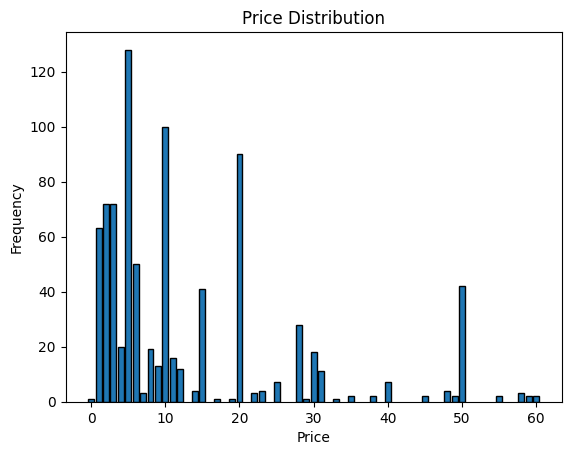

In [8]:
price_distribution_without_outlier = pd.Series([item.price for item in filtered_prices_for_outlier]).value_counts().sort_index()
plt.bar(price_distribution_without_outlier.index, price_distribution_without_outlier.values, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

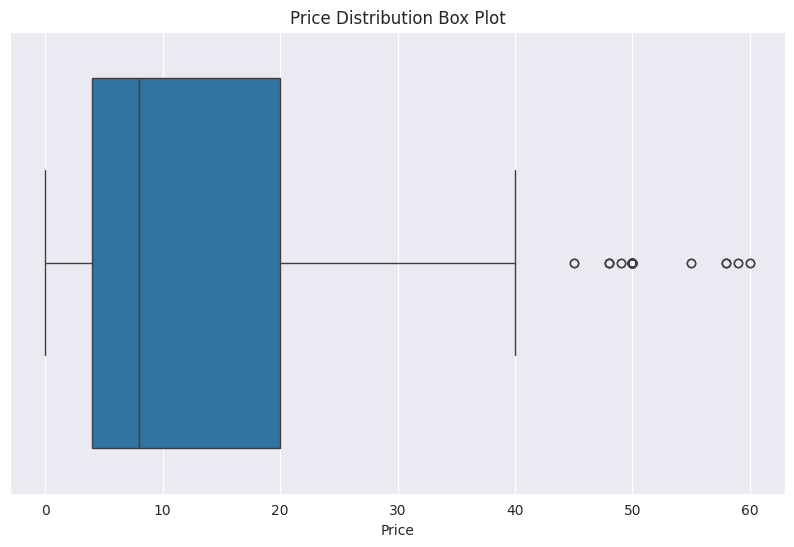

In [44]:
df = pd.DataFrame([item.price for item in filtered_prices_for_outlier], columns=['Price'])

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title('Price Distribution Box Plot')
plt.xlabel('Price')
plt.show()

## Cluster creation

### without outlier removal

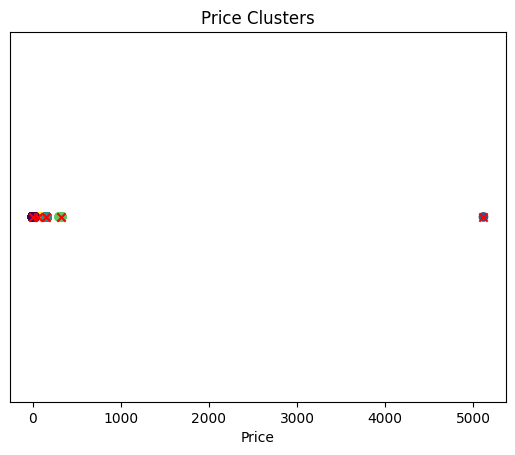

In [34]:
prices_array = np.array(filtered_prices).reshape(-1, 1)

# we assume 4 clusters: S, A, B, C
kmeans_with_outlier = KMeans(n_clusters=4, random_state=0)
price_clusters = kmeans_with_outlier.fit_predict(prices_array)

price_cluster_centers = kmeans_with_outlier.cluster_centers_ # for visualization

plt.scatter(prices_array, [0]*len(prices_array), c=price_clusters, cmap='viridis', marker='o')
plt.scatter(price_cluster_centers, [0]*len(price_cluster_centers), color='red', marker='x')  # cluster centers
plt.title('Price Clusters')
plt.xlabel('Price')
plt.yticks([])  # no need foy-axis
plt.show()

### with outlier removal

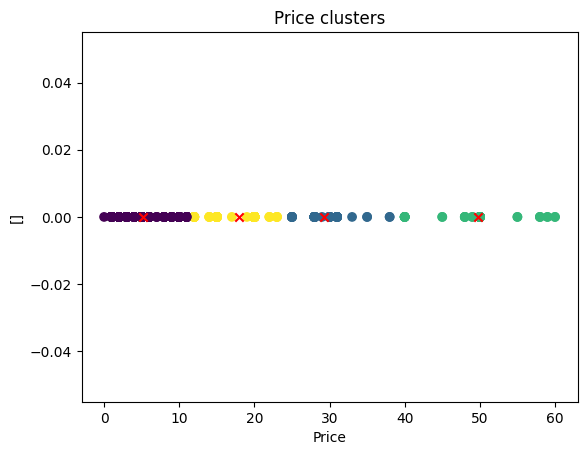

In [21]:
prices_array_without_outlier = np.array([item.price for item in filtered_prices_for_outlier]).reshape(-1, 1)

kmeans_without_outlier = KMeans(n_clusters=4, random_state=0)
price_without_outlier_clusters = kmeans_without_outlier.fit_predict(prices_array_without_outlier)

price_without_outlier_clusters_centers = kmeans_without_outlier.cluster_centers_ # for visualization

plt.scatter(prices_array_without_outlier, [0]*len(prices_array_without_outlier), c=price_without_outlier_clusters, cmap='viridis', marker='o')
plt.scatter(price_without_outlier_clusters_centers, [0]*len(price_without_outlier_clusters_centers), color='red', marker='x')  # cluster centers
plt.title('Price clusters')
plt.xlabel('Price')
plt.ylabel([])
plt.show()

### elbow method for cluster number selection

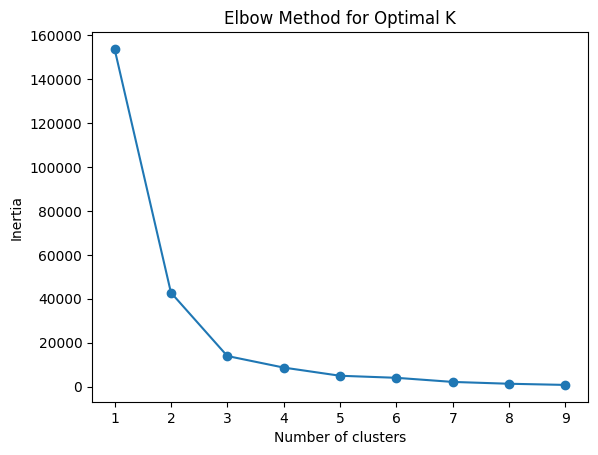

In [22]:
cluster_inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(prices_array_without_outlier)
    cluster_inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), cluster_inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

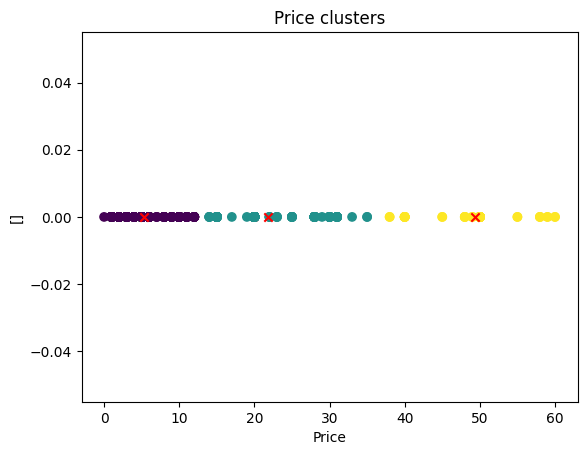

In [23]:
kmeans_without_outlier_elbow = KMeans(n_clusters=3, random_state=0)
price_without_outlier_clusters_elbow = kmeans_without_outlier_elbow.fit_predict(prices_array_without_outlier)

price_without_outlier_clusters_centers_elbow = kmeans_without_outlier_elbow.cluster_centers_ # for visualization

plt.scatter(prices_array_without_outlier, [0]*len(prices_array_without_outlier), c=price_without_outlier_clusters_elbow, cmap='viridis', marker='o')
plt.scatter(price_without_outlier_clusters_centers_elbow, [0]*len(price_without_outlier_clusters_centers_elbow), color='red', marker='x')  # cluster centers
plt.title('Price clusters')
plt.xlabel('Price')
plt.ylabel([])
plt.show()